# Prediction of a stock

## Αρχικά καλούμε τις βιβλιοθήκες που θα χρησιμοποιήσουμε στον κώδικα μας 

In [1]:
from pyrcn.echo_state_network import ESNRegressor
import pandas as pd
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
import math
import csv



## Ξεκινάμε να επεξεργαζόμαστε τα δεδομένα μας για να τα φέρουμε στην μορφή που χρειάζεται

In [2]:
# ─────────────────── 1. Φόρτωση ακριβώς ως κείμενο ───────────────────
raw = pd.read_csv(
    r"C:\Users\chilly\Desktop\EURGBP_M15.csv",
    sep='\t',            # πραγματικοί tab διαχωριστές μέσα στα quotes
    engine='python',
    quoting=csv.QUOTE_NONE,   # αγνόησε τα περικλειστικά "
    header=None,              # κάθε γραμμή έχει την ίδια δομή
    dtype=str                 # κράτησε τα πάντα ως συμβολοσειρές προς το παρόν
)

# ─────────────────── 2. Αφαίρεση των υπολειπόμενων εισαγωγικών ───────────────────
raw = raw.replace('"', '', regex=True)

# ─────────────────── 3. Προώθηση της πρώτης γραμμής σε επικεφαλίδα ───────────────────
raw.columns = raw.iloc[0]
df = raw.iloc[1:].reset_index(drop=True)

# ─────────────────── 4. Διαχωρισμός ημερομηνίας & ώρας σε ξεχωριστές στήλες ───────────────────
# Στο αρχείο σου είναι ήδη ξεχωριστές (<DATE> και <TIME>), οπότε απλώς μετονομάζουμε και κάνουμε cast
df = df.rename(columns={'<DATE>': 'date', '<TIME>': 'time'})

# αν είχες ημερομηνία+ώρα σε μία στήλη, χρησιμοποιείς:
# df[['date', 'time']] = df['date_time_col'].str.split(' ', 1, expand=True)

# ─────────────────── 5. Μετατροπή σε κατάλληλους τύπους δεδομένων ───────────────────
df['date'] = pd.to_datetime(df['date'], format='%Y.%m.%d').dt.date
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# οι υπόλοιπες στήλες που είναι αριθμητικές
num_cols = df.columns.difference(['date', 'time'])
df[num_cols] = df[num_cols].apply(pd.to_numeric)

# ─────────────────── 6. Δημιουργία πλήρους datetime index (προαιρετικό αλλά χρήσιμο) ───────────────────
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
df = df.set_index('datetime')

# Τώρα έχεις:
#   • index: πλήρης χρονική σφραγίδα
#   • στήλη 'date': αντικείμενο python `datetime.date`
#   • στήλη 'time': αντικείμενο python `datetime.time`
#   • 7 αριθμητικές στήλες τύπου OHLC κ.λπ.
print(df.head())



0                          date      time   <OPEN>   <HIGH>    <LOW>  <CLOSE>  \
datetime                                                                        
2024-01-02 00:00:00  2024-01-02  00:00:00  0.86724  0.86753  0.86717  0.86744   
2024-01-02 00:15:00  2024-01-02  00:15:00  0.86744  0.86768  0.86722  0.86751   
2024-01-02 00:30:00  2024-01-02  00:30:00  0.86756  0.86781  0.86704  0.86725   
2024-01-02 00:45:00  2024-01-02  00:45:00  0.86736  0.86744  0.86700  0.86737   
2024-01-02 01:00:00  2024-01-02  01:00:00  0.86738  0.86738  0.86682  0.86687   

0                    <TICKVOL>  <VOL>  <SPREAD>  
datetime                                         
2024-01-02 00:00:00         52      0        51  
2024-01-02 00:15:00         75      0         3  
2024-01-02 00:30:00        153      0         5  
2024-01-02 00:45:00         95      0         3  
2024-01-02 01:00:00        299      0         2  


In [3]:
df

,date,time,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
datetime,,,,,,,,,
2024-01-02 00:00:00,2024-01-02,00:00:00,0.86724,0.86753,0.86717,0.86744,52,0,51
2024-01-02 00:15:00,2024-01-02,00:15:00,0.86744,0.86768,0.86722,0.86751,75,0,3
2024-01-02 00:30:00,2024-01-02,00:30:00,0.86756,0.86781,0.86704,0.86725,153,0,5
2024-01-02 00:45:00,2024-01-02,00:45:00,0.86736,0.86744,0.86700,0.86737,95,0,3
2024-01-02 01:00:00,2024-01-02,01:00:00,0.86738,0.86738,0.86682,0.86687,299,0,2
...,...,...,...,...,...,...,...,...,...
2025-04-11 22:45:00,2025-04-11,22:45:00,0.86701,0.86737,0.86690,0.86727,732,0,22
2025-04-11 23:00:00,2025-04-11,23:00:00,0.86727,0.86760,0.86710,0.86753,431,0,21
2025-04-11 23:15:00,2025-04-11,23:15:00,0.86753,0.86830,0.86748,0.86819,268,0,20


## Αφαιρούμε τον index για να έχουμε τις 9 στείλες που μας ενδιαφέρουν

In [4]:
df = df.reset_index(drop=True) 

In [5]:
df

,date,time,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2024-01-02,00:00:00,0.86724,0.86753,0.86717,0.86744,52,0,51
1,2024-01-02,00:15:00,0.86744,0.86768,0.86722,0.86751,75,0,3
2,2024-01-02,00:30:00,0.86756,0.86781,0.86704,0.86725,153,0,5
3,2024-01-02,00:45:00,0.86736,0.86744,0.86700,0.86737,95,0,3
4,2024-01-02,01:00:00,0.86738,0.86738,0.86682,0.86687,299,0,2
...,...,...,...,...,...,...,...,...,...
31779,2025-04-11,22:45:00,0.86701,0.86737,0.86690,0.86727,732,0,22
31780,2025-04-11,23:00:00,0.86727,0.86760,0.86710,0.86753,431,0,21
31781,2025-04-11,23:15:00,0.86753,0.86830,0.86748,0.86819,268,0,20
31782,2025-04-11,23:30:00,0.86819,0.86846,0.86793,0.86808,513,0,19


## Μετανομασία των στειλών 

In [6]:
df.columns = ['date','time','open','high','low','close','tickvol','spread','real_vol']



In [7]:
df

,date,time,open,high,low,close,tickvol,spread,real_vol
0,2024-01-02,00:00:00,0.86724,0.86753,0.86717,0.86744,52,0,51
1,2024-01-02,00:15:00,0.86744,0.86768,0.86722,0.86751,75,0,3
2,2024-01-02,00:30:00,0.86756,0.86781,0.86704,0.86725,153,0,5
3,2024-01-02,00:45:00,0.86736,0.86744,0.86700,0.86737,95,0,3
4,2024-01-02,01:00:00,0.86738,0.86738,0.86682,0.86687,299,0,2
...,...,...,...,...,...,...,...,...,...
31779,2025-04-11,22:45:00,0.86701,0.86737,0.86690,0.86727,732,0,22
31780,2025-04-11,23:00:00,0.86727,0.86760,0.86710,0.86753,431,0,21
31781,2025-04-11,23:15:00,0.86753,0.86830,0.86748,0.86819,268,0,20
31782,2025-04-11,23:30:00,0.86819,0.86846,0.86793,0.86808,513,0,19


## Δημιουργία γραφήματος για το κλείσιμο της τιμής

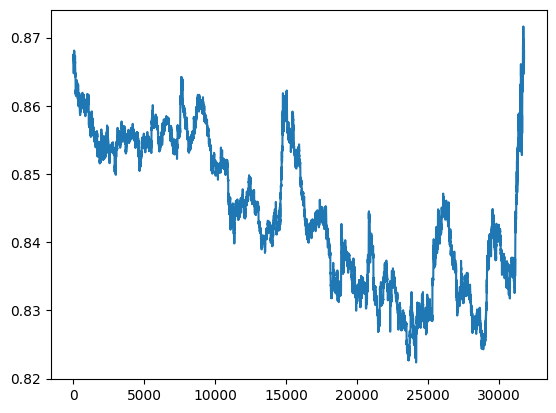

In [8]:
plt.plot(df.close)

## Κλασική “sliding-window” μετατροπή της μονοδιάστατης χρονοσειράς σε πίνακα εισόδου X διαστάσεων N×50 και αντίστοιχο διάνυσμα στόχων y
## 1. Δημιουργία παραθύρων
### Ολισθαίνουμε ένα παράθυρο μήκους 51 επάνω στη σειρά:
### Είσοδοι: οι πρώτες 50 τιμές.
### Στόχος: η 51η τιμή.
## 2. Δομές δεδομένων
### Το X_ins γίνεται λίστα από μονοδιάστατους πίνακες (arrays), καθένας σχήματος (50,)
### Το y_targets είναι λίστα με αριθμούς (scalars) — η “επόμενη” τιμή κλεισίματος που θέλουμε να προβλέψουμε
### Το prices κρατάει το τελευταίο στοιχείο κάθε παραθύρου—χρήσιμο για κανονικοποίηση ή υπολογισμό απόδοσης σε σχέση με την πιο πρόσφατη τιμή.




In [9]:
# Διαχωρισμός δεδομένων σε είσοδοι (inputs) και στόχοι (outputs) για tuning υπερπαραμέτρων
y_targets = list()
X_ins = list()
prices = list()
# Δημιουργούμε sliding windows των 51 τιμών: 50 για είσοδο + 1 για στόχο
for i in range(len(df)):
    end = i+50+1
    if end > len(df):
        break # σταματάμε όταν δεν υπάρχουν άλλα πλήρη παράθυρα
        
# Παίρνουμε το slice των 51 τιμών από το column 'close'
    seq1 = df.close[i:end]
    seq1 = seq1.reset_index(drop=True)
    
# Ο στόχος είναι η τελευταία τιμή του slice (51η)
    y_targets.append(seq1.iloc[-1])
# Η είσοδος είναι οι πρώτες 50 τιμές
    seq = seq1[:-1]
# Αποθηκεύουμε την τελευταία τιμή της εισόδου (συνήθως για κανονικοποίηση)
    price = seq.iloc[-1]
    prices.append(price)
    seq = np.array(seq)
    seq = np.round(seq,5)
    X_ins.append(seq)
    
# Τελικά παίρνουμε έναν πίνακα X με σχήμα (n_samples, 50)
X = np.array(X_ins)




### Αυτό σχεδιάζει το 400ό παράθυρο εισόδου (δηλαδή το 50-βηματικό ιστορικό τιμών από t=400 έως t=449), 
### ώστε να μπορείτε να δείτε πώς μοιάζει ένα τυπικό δείγμα εκπαίδευσης.


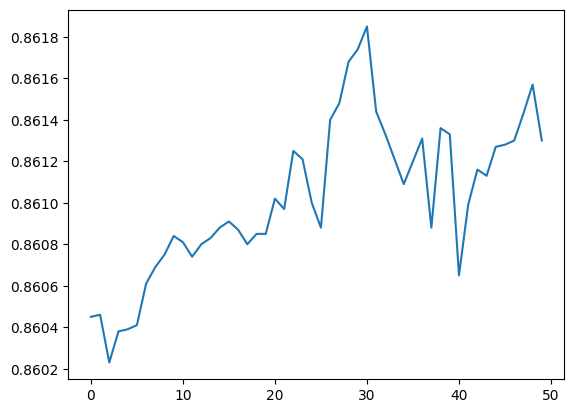

In [10]:
plt.plot(X[400])

## Διαχωρισμός σε training set & test set
### Το πρώτο 80% θα χρησιμοποιηθεί για το training set


In [13]:
#Διαχωρισμός σε training set και test set
ts = round(len(X)*0.8)
#inputs

# το πρώτο 80% train set και το υπόλοιπο test set
train_set = X[:ts]
test_set = X[ts:]

#outputs

y_train = y_targets[:ts]
y_test = y_targets[ts:]

# ο λόγος που χρησιμοποιούμε numpy vectors είναι γιατί πολλές βιβλιοήκες ML τα χρησιμοποιούν
y_train = np.array(y_train)
y_test = np.array(y_test)

## Εισάγουμε κάποιες βιβλιοθήκες
### 1) from sklearn.linear_model import Ridge
### Η παλινδρόμηση Ridge θα είναι το read‐out layer: ένα γραμμικό μοντέλο με L₂ κανονικοποίηση,
### που μαθαίνει να χαρτογραφεί τις καταστάσεις του reservoir στις τιμές‐στόχους.
### 2) from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
### Το GridSearchCV εκτελεί εξαντλητική αναζήτηση σε πλέγμα υπερπαραμέτρων
### (π.χ. διαφορετικά spectral_radius, leakage κ.λπ.), χρησιμοποιώντας cross‐validation
### για να επιλέξει τον καλύτερο συνδυασμό.
### Το TimeSeriesSplit είναι καταμεριστής cross‐validation που διατηρεί τη χρονολογική σειρά
### (χωρίς τυχαιοποίηση), παρέχοντας σωστά train/test folds για χρονοσειρές.
### 3) from sklearn.metrics import make_scorer, mean_squared_error
### Το mean_squared_error είναι η συνάρτηση κόστους (loss) που θα ελαχιστοποιήσετε.
### Το make_scorer(mean_squared_error, greater_is_better=False) το “τυλίγει”
### ώστε να μπορεί να περαστεί στο GridSearchCV (απαιτεί αντικείμενο scorer).
### 4) from pyrcn.model_selection import SequentialSearchCV
### Ένας PyRCN‐specific orchestrator που εκτελεί διαδοχικά βήματα tuning
### (π.χ. πρώτα input_scaling, μετά spectral_radius κ.λπ.), σταθεροποιώντας 
### κάθε φορά τις καλύτερες παραμέτρους.
### 5) from pyrcn.metrics import mean_squared_error
### Η δική του έκδοση του MSE στο PyRCN (ίδια μαθηματικά αλλά συμβατή με το API).
### 6) from pyrcn.echo_state_network import ESNRegressor
### Η κύρια κλάση που υλοποιεί το Echo State Network για regression.
### Τη δημιουργείτε με τα blocks InputToNode και NodeToNode, συν ένα read‐out (Ridge).
### 7) from pyrcn.base.blocks import InputToNode, NodeToNode
### Το InputToNode καθορίζει πώς οι είσοδοι τροφοδοτούνται (και κλιμακώνονται)
### σε κάθε νευρώνα του reservoir.
### Το NodeToNode καθορίζει τις εσωτερικές επαναληπτικές συνδέσεις
### (μέγεθος, spectral radius, leakage, sparsity κ.λπ.).
### 8) from matplotlib import pyplot as plt
### Βασική βιβλιοθήκη σχεδιασμού γραφημάτων για οπτικοποίηση:
### καμπύλες κόστους, προβλέψεις vs πραγματικά, RMSE vs υπερπαράμετροι κ.λπ.


In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from pyrcn.model_selection import SequentialSearchCV
from pyrcn.metrics import mean_squared_error
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.metrics import make_scorer,mean_squared_error

from matplotlib import pyplot as plt

# Βήμα 1: Αρχική ρύθμιση και Grid Search του ESN

In [15]:
# Απενεργοποιούμε όλες τις προειδοποιήσεις για καθαρό output
import warnings
warnings.filterwarnings('ignore')

# initially_fixed_params: λεξικό με σταθερές παραμέτρους του ESN για αυτό το βήμα.
#   hidden_layer_size=400      : αριθμός κόμβων στο reservoir
#   input_activation='identity': χωρίς μη γραμμικό μετασχηματισμό εισόδου
#   reservoir_activation='tanh': ενεργοποίηση μέσα στο reservoir
#   bidirectional=False        : καμία οπισθοδρόμηση (μόνο προς τα εμπρός)
#   alpha=1e-5                 : δύναμη κανονικοποίησης Ridge για το read-out
#   k_rec=10                   : κάθε κόμβος έχει 10 επαναληπτικές συνδέσεις
#   random_state=42            : αναπαραγωγιμότητα τυχαίων βαρών
#   requires_sequence=False    : δεν απαιτείται η ολόκληρη ακολουθία κατά το fit
initially_fixed_params = {
    'hidden_layer_size': 400,
    'input_activation': 'identity',
    'reservoir_activation': 'tanh',
    'bidirectional': False,
    'alpha': 1e-5,
    'k_rec': 10,
    'random_state': 42,
    'requires_sequence': False
}

# step1_esn_params: grid υπερπαραμέτρων για το πρώτο tuning βήμα
#   → συνολικά 2×2×2 = 8 δυνατότητες
step1_esn_params = {
    'input_scaling':  (0.1, 0.2),
    'spectral_radius': (0.1, 0.2),
    'leakage':         (0.1, 0.2)
}

# Μετατρέπουμε το MSE σε scorer για το GridSearchCV, ώστε να το ελαχιστοποιεί
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)

# Επιπλέον kwargs για το GridSearchCV:
#   verbose=5 : εμφάνιση προόδου ανά fold
#   scoring=scorer : χρήση του MSE scorer
#   n_jobs=1 : σειριακή εκτέλεση (θέσε -1 για παράλληλη)
kwargs_step1 = {
    'verbose': 5,
    'scoring': scorer,
    'n_jobs': 1
}

# Καθορίζουμε το βήμα αναζήτησης:
#   ('βημα', ΜέθοδοςCV, grid παραμέτρων, επιπλέον kwargs)
searches = [
    ('step1', GridSearchCV, step1_esn_params, kwargs_step1)
]

# Δημιουργούμε το ESNRegressor με Ridge read-out και τις σταθερές παραμέτρους
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
esn = ESNRegressor(regressor=Ridge(), **initially_fixed_params)

# Εκτελούμε SequentialSearchCV: 
#   1) παίρνει το base ESN
#   2) τρέχει το 'step1' grid search (8 συνδυασμοί) με TimeSeriesSplit
#   3) επιλέγει τις βέλτιστες input_scaling, spectral_radius, leakage
from pyrcn.model_selection import SequentialSearchCV
esn_opti = SequentialSearchCV(esn, searches=searches).fit(train_set, y_train)

# Εμφανίζουμε το βελτιστοποιημένο ESN με τις επιλεγμένες παραμέτρους
print(esn_opti)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.000 total time=   2.3s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.000 total time=   1.8s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.000 total time=   1.8s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.000 total time=   1.9s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.000 total time=   2.1s
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.000 total time=   1.9s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.000 total time=   1.8s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.000 total time=   1.8s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.000 total time=   1.8s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spec

In [16]:
## Καθορίζουμε την λίστα υποψήγιων input_scaling τιμών
in_scaling = [0.1,0.2,0.3,0.4]  # θα περιηγιθούμε σε αύτες για να βρούμε την καλύτερη τιμή

In [17]:
# Δημιουργούμε μια λίστα για να αποθηκεύσουμε τα RMSE για κάθε input_scaling
rmses = list()
# Βρόχος πάνω σε όλες τις τιμές του in_scaling
for i in range(len(in_scaling)):
    in_s = in_scaling[i]  # τρέχουσα τιμή input_scaling

    # Ορίζουμε το μπλοκ που τροφοδοτεί το reservoir με είσοδο

    base_input_to_nodes = InputToNode(
        hidden_layer_size=400,        # πλήθος κόμβων reservoir
        input_activation='identity',  # χωρίς μη γραμμική ενεργοποίηση στην είσοδο
        k_in=1,                       # κάθε είσοδος συνδέεται με κάθε κόμβο
        input_scaling=in_s,           # κλιμάκωση εισόδου
        bias_scaling=0.0              # χωρίς bias
    )
    
     # Ορίζουμε τις επαναληπτικές συνδέσεις του reservoir
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=400, # ίδιο πλήθος κόμβων
        spectral_radius=0.2,   # σταθερή φασματική ακτίνα
        leakage=0.2,           # σταθερός ρυθμός διαρροής
        k_rec=10               # κάθε κόμβος συνδέεται με 10 τυχαίους
    )
     
    # Δημιουργούμε το ESN με Ridge read-out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8)
    )
    
    # Εκπαιδεύουμε το ESN πάνω στο training set
    esn.fit(train_set, y_train)
    
    # Παράγουμε προβλέψεις για το ίδιο training set
    predictions = esn.predict(train_set)
    
    # Υπολογίζουμε το MSE και έπειτα το RMSE
    MSE = mean_squared_error(predictions,y_train)
    rmse = math.sqrt(MSE)
        
    # Εκτυπώνουμε και αποθηκεύουμε το RMSE
    print(rmse)
    rmses.append(rmse)
    

0.00025187171703073776
0.00023734466670621824
0.0002372688488984704
0.0002372096849482667


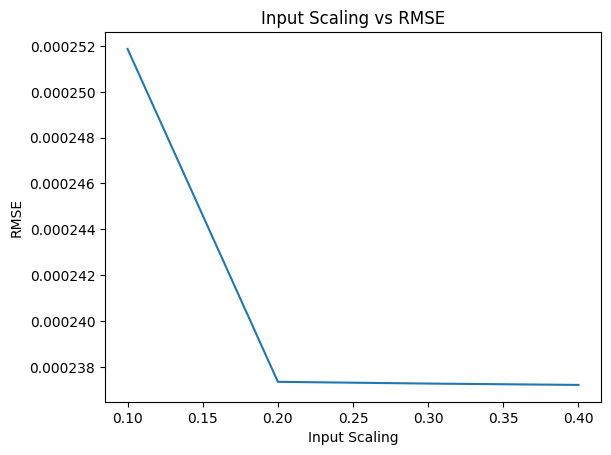

In [18]:
plt.title("Input Scaling vs RMSE")
plt.xlabel("Input Scaling")
plt.ylabel("RMSE")
plt.plot(in_scaling,rmses)

## Φτιαχνουμε μια λίστα με τις πιθανές τιμές των κόμβων

In [19]:
nodes = [200,400,800,1000]

## Θέλουμε να δούμε πώς η απόδοση του ESN (μετρούμενη ως RMSE στο training set) αλλάζει καθώς αλλάζουμε το πλήθος των νευρώνων (nodes) στο εσωτερικό reservoir.

## Λιγότεροι κόμβοι → μικρότερη χωρητικότητα μνήμης, λιγότερο πολύπλοκο μοντέλο

## Περισσότεροι κόμβοι → περισσότερη χωρητικότητα, αλλά και κίνδυνος υπερεκπαίδευσης ή μεγαλύτερο κόστος υπολογισμού



In [20]:


# Εδώ θα αποθηκεύσουμε τα RMSE για κάθε μέγεθος
rmses = []

# Βρόχος πάνω σε κάθε αριθμό κόμβων
for i in range(len(nodes)):
    n_nodes = nodes[i]  # τρέχουσα τιμή hidden_layer_size

    # 1) Ορισμός του μπλοκ εισόδου με n_nodes νευρώνες
    base_input_to_nodes = InputToNode(
        hidden_layer_size=n_nodes,       # πλήθος νευρώνων
        input_activation='identity',     # χωρίς μη-γραμμικότητα στην είσοδο
        k_in=1,                          # πλήρης σύνδεση input → κάθε νευρώνα
        input_scaling=0.4,               # σταθερή κλιμάκωση εισόδου
        bias_scaling=0.0                 # χωρίς bias
    )

    # 2) Ορισμός του μπλοκ επαναληπτικών συνδέσεων (reservoir)
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=n_nodes,  # ίδιο πλήθος νευρώνων
        spectral_radius=0.2,        # σταθερή φασματική ακτίνα
        leakage=0.2,                # σταθερή διαρροή μνήμης
        k_rec=10                    # 10 τυχαίες επαναληπτικές συνδέσεις ανά νευρώνα
    )

    # 3) Κατασκευή ESNRegressor με Ridge read‐out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8)  # πολύ ελαφριά κανονικοποίηση
    )

    # 4) Εκπαίδευση του ESN στο training set
    esn.fit(train_set, y_train)

    # 5) Πρόβλεψη πάνω στο ίδιο training set
    predictions = esn.predict(train_set)

    # 6) Υπολογισμός MSE και RMSE
    MSE = mean_squared_error(predictions, y_train)
    rmse = math.sqrt(MSE)

    # 7) Εμφάνιση και αποθήκευση του αποτελέσματος
    print(f"n_nodes={n_nodes} → RMSE={rmse:.20f}")
    rmses.append(rmse)


n_nodes=200 → RMSE=0.00023733134206314156
n_nodes=400 → RMSE=0.00023722518357099118
n_nodes=800 → RMSE=0.00023698168694372322
n_nodes=1000 → RMSE=0.00023689533843970160


## Γράφημα που δείχνει ποσο μεταβάλεται το σφάλμα με βάση των αριθμών των κόμβων που επιλέχθηκε

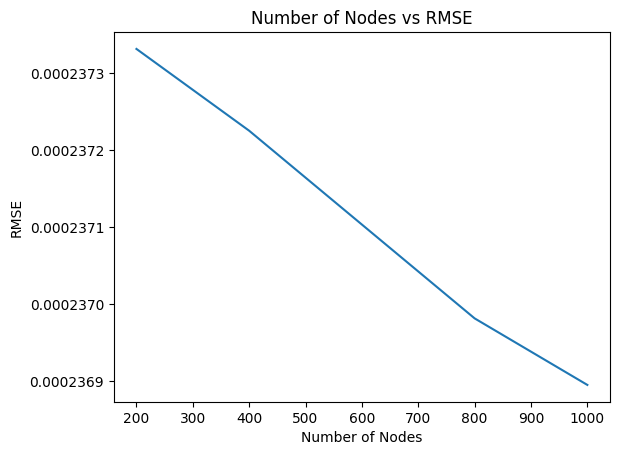

In [21]:
plt.title("Number of Nodes vs RMSE")
plt.xlabel("Number of Nodes")
plt.ylabel("RMSE")
plt.plot(nodes,rmses)

## Σε αυτό το βήμα διαμορφώνουμε την αρχιτεκτονική του Echo State Network, δημιουργώντας: 
### Το μπλοκ εισόδου (InputToNode) που χαρτογραφεί και κλιμακώνει τις εξωτερικές τιμές στο reservoir.
### Το επαναληπτικό μπλοκ (NodeToNode) που ορίζει τη δυναμική και τις εσωτερικές συνδέσεις του reservoir.
### Τον τελικό ESNRegressor, συνδυάζοντας τα δύο blocks με έναν γραμμικό Ridge read-out, έτοιμο να εκπαιδευτεί.

In [22]:

# Ορισμός του μπλοκ εισόδου (Input → Reservoir)
base_input_to_nodes = InputToNode(
    hidden_layer_size=1000,   # reservoir με 1000 νευρώνες
    input_activation='identity',  # η είσοδος περνάει αυτούσια, χωρίς μη-γραμμική ενεργοποίηση
    k_in=1,                       # κάθε διάσταση εισόδου συνδέεται με κάθε νευρώνα
    input_scaling=0.4,            # κλιμακώνει την ισχύ του σήματος εισόδου στο 0.4
    bias_scaling=0.0              # δεν προστίθεται επιπλέον bias
)

# Ορισμός του επαναληπτικού μπλοκ (Reservoir → Reservoir)
base_nodes_to_nodes = NodeToNode(
    hidden_layer_size=1000,  # ίδια διάσταση reservoir: 1000 νευρώνες
    spectral_radius=0.2,     # φασματική ακτίνα για σταθερότητα της δυναμικής
    leakage=0.2,             # ρυθμός "διαρροής" μνήμης των νευρώνων
    k_rec=10                 # κάθε νευρώνας έχει 10 τυχαίες επαναληπτικές συνδέσεις
)

# Συνδυασμός σε ESNRegressor με Ridge read-out
esn = ESNRegressor(
    input_to_node=base_input_to_nodes,      # το μπλοκ εισόδου που ορίσαμε
    node_to_node=base_nodes_to_nodes,       # το επαναληπτικό μπλοκ
    regressor=Ridge(alpha=1e-8)             # γραμμικός read-out με πολύ ελαφριά κανονικοποίηση
)


In [23]:
# Λίστα με τα μήκη ιστορικού (μεγέθη παραθύρου) που θα αξιολογηθούν ως είσοδοι για το ESN
windows = [40,60,80,100]

## Δημιουργία σετ εισόδων και στόχων για εκπαίδευση ESN βάσει sliding window.


In [24]:
def receive_training_sets(window):

# Ετοιμάζουμε λίστες για τους στόχους, τις εισόδους και τις τιμές «πριν»
    y_targets = list()
    X_ins     = list()
    prices    = list()


    # Ολισθαίνουμε ένα παράθυρο μήκους window+1 πάνω στη σειρά τιμών κλεισίματος
    for b in range(len(df)):
        end = b + window + 1
        if end > len(df):
            break  # σταματάμε όταν δεν υπάρχουν αρκετά δεδομένα για πλήρες παράθυρο

        # Παίρνουμε το slice των window+1 τιμών: οι πρώτες window για είσοδο, η τελευταία για στόχο
        seq1 = df.close[b:end]

        # Ο στόχος (target) είναι η τελευταία τιμή του slice
        y_targets.append(seq1.iloc[-1])

        # Η είσοδος είναι οι πρώτες window τιμές
        seq = seq1[:-1]

        # Καταγράφουμε την τελευταία τιμή της εισόδου (για κανονικοποίηση ή έλεγχο κατεύθυνσης)
        prices.append(seq.iloc[-1])

        # Μετατρέπουμε τη σειρά εισόδου σε NumPy array και την αποθηκεύουμε
        X_ins.append(np.array(seq))

    # Στοίχιση όλων των παραθύρων εισόδου σε έναν πίνακα (n_samples, window)
    train_set = np.array(X_ins)

    # Μετατροπή λίστας στόχων και τιμών «πριν» σε πίνακες NumPy
    y_train = np.array(y_targets)
    prev    = np.array(prices)

    return train_set, y_train, prev

In [25]:
def train(train_set,y_train,previous):
    esn.fit(train_set, y_train)

    
    predictions = esn.predict (train_set)

        
    MSE = mean_squared_error(predictions,y_train)
    rmse = math.sqrt(MSE)
    
    return rmse

In [26]:

rmses = []

## Αυτός ο βρόχος δοκιμάζει διαφορετικά μεγέθη «παραθύρου» (window sizes) και καταγράφει πόσο καλά εκπαιδεύεται το ESN σε κάθε περίπτωση:

In [27]:
# Βρόχος σε όλους τους μεγέθους παραθύρου της λίστας 'windows'
for n in range(len(windows)):
    window = windows[n]  # τρέχον μέγεθος παραθύρου

    # Δημιουργούμε τα training δεδομένα (παράθυρα εισόδου, στόχοι, προηγούμενες τιμές)
    train_set, y_train, prev = receive_training_sets(window)

    # Εκπαιδεύουμε το ESN με αυτά τα δεδομένα και υπολογίζουμε το RMSE
    rmse = train(train_set, y_train, prev)

    # Εκτυπώνουμε το RMSE για το τρέχον μέγεθος παραθύρου
    print(f"window={window} -> RMSE={rmse:.15f}")

    # Αποθηκεύουμε το RMSE στη λίστα για μελλοντική ανάλυση ή οπτικοποίηση
    rmses.append(rmse)


window=40 -> RMSE=0.000262860472241
window=60 -> RMSE=0.000262464100018
window=80 -> RMSE=0.000262064603830
window=100 -> RMSE=0.000261696777449


## Γράφημα μεταβολής του σφάλματος με βάση το windows size

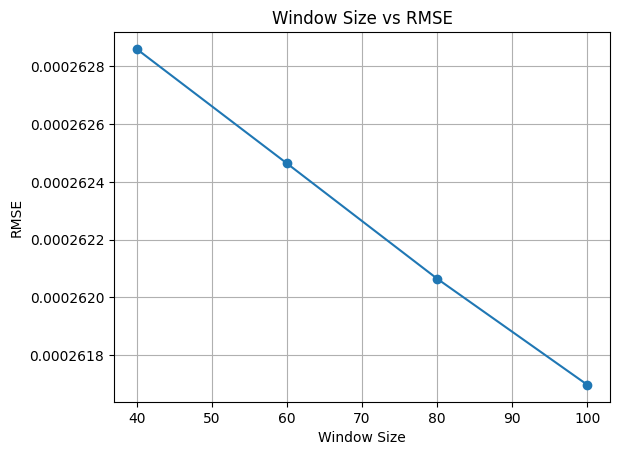

In [28]:
plt.title("Window Size vs RMSE")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.plot(windows, rmses, marker='o')  # note: use rmses, not rmse
plt.grid(True)
plt.show()


## Κλασική “sliding-window” μετατροπή της μονοδιάστατης χρονοσειράς σε πίνακα εισόδου X διαστάσεων N×50 και αντίστοιχο διάνυσμα στόχων y
## 1. Δημιουργία παραθύρων
### Ολισθαίνουμε ένα παράθυρο μήκους 51 επάνω στη σειρά:
### Είσοδοι: οι πρώτες 50 τιμές.
### Στόχος: η 51η τιμή.
## 2. Δομές δεδομένων
### Το X_ins γίνεται λίστα από μονοδιάστατους πίνακες (arrays), καθένας σχήματος (50,)
### Το y_targets είναι λίστα με αριθμούς (scalars) — η “επόμενη” τιμή κλεισίματος που θέλουμε να προβλέψουμε
### Το prices κρατάει το τελευταίο στοιχείο κάθε παραθύρου—χρήσιμο για κανονικοποίηση ή υπολογισμό απόδοσης σε σχέση με την πιο πρόσφατη τιμή.

In [29]:
y_targets = list()
X_ins = list()
prices = list()
for i in range(len(df)):
    end = i+50+1
    if end > len(df):
        break
    seq1 = df.close[i:end]
    seq1 = seq1.reset_index(drop=True)

    y_targets.append(seq1.iloc[-1])
    
    seq = seq1[:-1]
    
    price = seq.iloc[-1]
    prices.append(price)
    seq = np.array(seq)
    seq = np.round(seq,5)
    X_ins.append(seq)
    

X = np.array(X_ins)

## Διαχωρισμός σε training set & test set
### Το πρώτο 80% θα χρησιμοποιηθεί για το training set


In [30]:
ts = round(len(X)*0.8)
#inputs
train_set = X[:ts]
test_set = X[ts:]
#outputs
y_train = y_targets[:ts]
y_test = y_targets[ts:]

y_train = np.array(y_train)
y_test = np.array(y_test)


In [31]:
# Εκπαίδευση (fit) του ESN στο training set
#   - Το ESN «μαθαίνει» τον γραμμικό read-out (Ridge) βασιζόμενο στις καταστάσεις του reservoir
#   - Χρησιμοποιεί train_set (X) και y_train (στόχους) για να υπολογίσει τα κατάλληλα βάρη
esn.fit(train_set, y_train)

# Πρόβλεψη (predict) του ίδιου training set
#   - Μετά την εκπαίδευση, παράγει τις τιμές που «πιστεύει» ότι αντιστοιχούν στα train_set
#   - Αποθηκεύουμε το αποτέλεσμα σε predictions_train
predictions_train = esn.predict(train_set)


## Σχεδιασμός των πρώτων 30 προβλέψεων του μοντέλου συγκριτικά με τις πραγματικές τιμές, ώστε να δεις σε ένα μικρό «παράθυρο» πώς τα πάει:


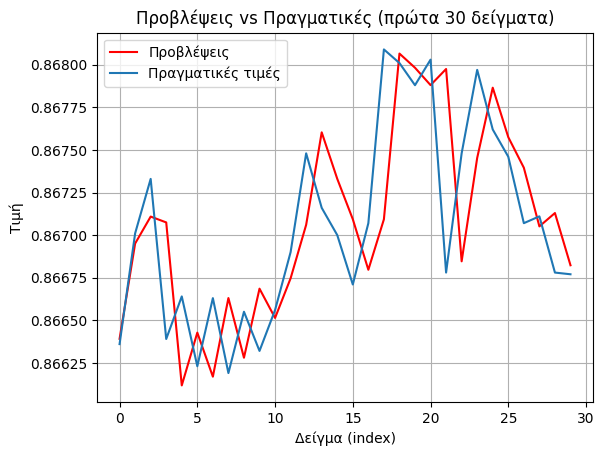

In [32]:
# Σχεδιάζουμε τις πρώτες 30 προβλέψεις (κόκκινη γραμμή)
plt.plot(predictions_train[:30], color='red', label='Προβλέψεις')

# Σχεδιάζουμε τις πρώτες 30 πραγματικές τιμές (μπλε γραμμή από προεπιλογή)
plt.plot(y_train[:30],       label='Πραγματικές τιμές')

# Προσθέτουμε υπόμνημα και άξονες
plt.legend()
plt.xlabel('Δείγμα (index)')
plt.ylabel('Τιμή')
plt.title('Προβλέψεις vs Πραγματικές (πρώτα 30 δείγματα)')
plt.grid(True)
plt.show()

## Αυτή η διαδικασία υπολογίζει πόσες φορές το ESN “έπιασε” σωστά την τάση (πάνω ή κάτω) της τιμής σε σχέση με την προηγούμενη τιμή του παραθύρου:

In [33]:
# Ορισμός των πινάκων για έλεγχο κατεύθυνσης πρόβλεψης
real        = y_train                # οι πραγματικές επόμενες τιμές
predictions = predictions_train      # οι προβλέψεις του ESN για το training set

# Το prev παίρνει τις «τελευταίες» τιμές κάθε παραθύρου εισόδου
prev = np.array(prices[:ts])

# Μετρητής σωστών προβλέψεων κατεύθυνσης
number = 0

# Βρόχος σε κάθε δείγμα για να ελέγξουμε αν το μοντέλο έπιασε
# σωστά αν η τιμή ανέβηκε ή έπεσε σε σχέση με την προηγούμενη τιμή
for i in range(len(real)):
    # Αν και η πραγματική και η προβλεπόμενη τιμή είναι πάνω
    # από το prev[i], μετράμε σωστή ανοδική πρόβλεψη
    if real[i] > prev[i] and predictions[i] > prev[i]:
        number += 1
    # Αν και οι δύο είναι κάτω από το prev[i], μετράμε σωστή καθοδική πρόβλεψη
    elif real[i] < prev[i] and predictions[i] < prev[i]:
        number += 1
    # Διαφορετικά δεν αυξάνουμε τον μετρητή

# Υπολογισμός ποσοστού επιτυχίας ως προς την κατεύθυνση (directional accuracy)
trues = number / len(real)
print(trues)  # π.χ. 0.513 σημαίνει 51.3% σωστές προβλέψεις κατεύθυνσης


0.5109701815890022


## esn.predict(test_set): χρησιμοποιεί το ήδη “εκπαιδευμένο” μοντέλο (esn.fit έχει ήδη τρέξει) ώστε να εκτιμήσει τις επόμενες τιμές για κάθε παράθυρο στο test_set.

### Το αποτέλεσμα predictions_test είναι ένας πίνακας με μήκος όμοιο με το test_set, που περιέχει τις προβλεπόμενες τιμές για κάθε δείγμα του test set.

In [34]:
# Παράγουμε τις προβλέψεις του ESN για τα νέα, αθέατα δεδομένα του test set
predictions_test = esn.predict(test_set)

In [35]:
len(predictions_test)

6347

In [36]:
len(y_test)

6347

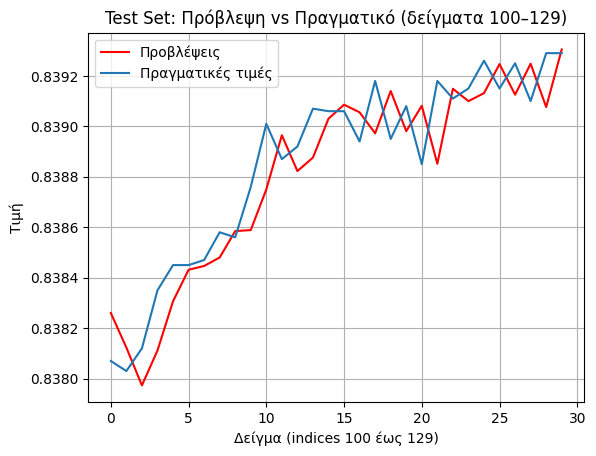

In [37]:
# Σχεδίασε τις προβλέψεις 100–129 (κόκκινη γραμμή)
plt.plot(predictions_test[100:130], color='red', label='Προβλέψεις')

# Σχεδίασε τις πραγματικές τιμές 100–129 (μπλε γραμμή)
plt.plot(y_test[100:130], label='Πραγματικές τιμές')

# Προσθήκη υπόμνηματος και τίτλων αξόνων
plt.legend()
plt.xlabel('Δείγμα (indices 100 έως 129)')
plt.ylabel('Τιμή')
plt.title('Test Set: Πρόβλεψη vs Πραγματικό (δείγματα 100–129)')
plt.grid(True)
plt.show()

## Αυτό το κομμάτι κώδικα υπολογίζει την «κατευθυντική ακρίβεια» (directional accuracy) του μοντέλου στο test set, δηλαδή το ποσοστό των φορών που μάντεψε σωστά αν η τιμή θα κινηθεί πάνω ή κάτω σε σχέση με την προηγούμενη τιμή.

In [38]:
# Ορισμός των πινάκων για έλεγχο κατεύθυνσης
real        = y_test                # πραγματικές τιμές-στόχοι
predictions = predictions_test      # προβλεπόμενες τιμές ESN
prev        = np.array(prices[ts:]) # τελευταία τιμή κάθε window για το test set

# Αρχικοποίηση μετρητή σωστών προβλέψεων κατεύθυνσης
number = 0

# Για κάθε δείγμα i, ελέγχουμε αν το μοντέλο μάντεψε σωστά την ανοδική/καθοδική κίνηση
for i in range(len(real)):
    # Σωστή ανοδική πρόβλεψη αν και η πραγματική και η προβλεπόμενη > prev[i]
    if real[i] > prev[i] and predictions[i] > prev[i]:
        number += 1
    # Σωστή καθοδική πρόβλεψη αν και οι δύο < prev[i]
    elif real[i] < prev[i] and predictions[i] < prev[i]:
        number += 1
    # Στις άλλες περιπτώσεις δεν μετράμε τίποτα

# Υπολογισμός ποσοστού επιτυχίας (directional accuracy)
trues = number / len(real)
print(trues)  # π.χ. 0.504 → 50.4% σωστές προβλέψεις κατεύθυνσης


0.5048054198834094
